# Custom Mask R-CNN Training

Training notebook for custom Mask R-CNN with EfficientNet backbone and CBAM attention.


In [2]:
!git clone https://github.com/michaelo-ponteski/isaid-instance-segmentation.git
%cd isaid-instance-segmentation/

Cloning into 'isaid-instance-segmentation'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 203 (delta 81), reused 166 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 3.17 MiB | 19.81 MiB/s, done.
Resolving deltas: 100% (81/81), done.
/kaggle/working/isaid-instance-segmentation


In [3]:
!git pull origin ponteski

From https://github.com/michaelo-ponteski/isaid-instance-segmentation
 * branch            ponteski   -> FETCH_HEAD
Updating ebf8d65..aa46ccc
Fast-forward
 .gitignore                  |  11 +
 config.yaml                 |  22 ++
 datasets/isaid_dataset.py   | 138 ++++++-
 models/__init__.py          |  35 ++
 models/backbone.py          | 230 ++++++++++++
 models/maskrcnn_model.py    | 365 ++++++++++--------
 models/roi_heads.py         | 226 +++++++++++
 notebooks/00_setup.ipynb    | 884 +++++++++++++++++++++++---------------------
 notebooks/01_training.ipynb | 269 ++++++++++++++
 requirements.txt            |   9 +
 training/__init__.py        |   4 +
 training/trainer.py         | 296 +++++++++++++++
 training/transforms.py      |  48 +++
 utils/__init__.py           |   7 +
 utils/overfit_test.py       |  47 +--
 15 files changed, 1966 insertions(+), 625 deletions(-)
 create mode 100644 .gitignore
 create mode 100644 config.yaml
 create mode 100644 models/backbone.py
 create mode

In [4]:
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("michaeloponteski/isaid-patches")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/isaid-patches


In [5]:
import torch
import matplotlib.pyplot as plt
import importlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 17.1 GB


In [6]:
# Reload modules for development
import datasets.isaid_dataset
import models.maskrcnn_model
import utils.overfit_test
import training.trainer
import training.transforms

importlib.reload(datasets.isaid_dataset)
importlib.reload(models.maskrcnn_model)
importlib.reload(utils.overfit_test)
importlib.reload(training.trainer)
importlib.reload(training.transforms)

from datasets.isaid_dataset import iSAIDDataset, visualize_sample
from models.maskrcnn_model import get_custom_maskrcnn
from utils.overfit_test import overfit_single_image_test
from training import Trainer

## Load Dataset


In [7]:
root_dir = path + "/iSAID_patches"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 16

In [ ]:
train_dataset = iSAIDDataset(root_dir, split="train")
val_dataset = iSAIDDataset(root_dir, split="val")

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}")

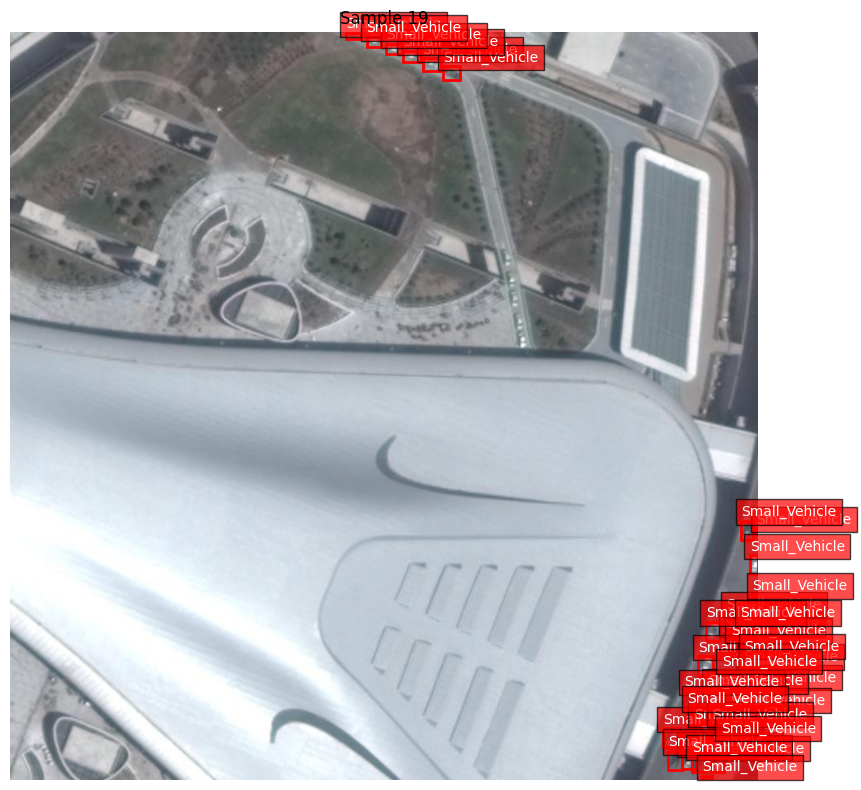

In [7]:
# Visualize a sample
visualize_sample(train_dataset, 19)

## Create Model


In [8]:
model = get_custom_maskrcnn(num_classes=num_classes, pretrained_backbone=True)

# Model info
info = model.get_model_info()
print(f"Total parameters: {info['total_parameters']:,}")
print(f"Trainable parameters: {info['trainable_parameters']:,}")
print(f"Model size: {info['model_size_mb']:.1f} MB")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


Total parameters: 24,315,626
Trainable parameters: 24,315,626
Model size: 92.9 MB


## Overfit Single Image Test

Sanity check - can the model learn to overfit a single image?


OVERFIT SINGLE IMAGE TEST

Image shape: torch.Size([3, 800, 800])
Number of instances: 33
Classes: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]

Training for 500 epochs...
Epoch [10/500], Loss: 2.0280
  loss_objectness: 0.6641
  loss_rpn_box_reg: 0.0611
  loss_classifier: 0.6288
  loss_box_reg: 0.1765
  loss_mask: 0.4975
Epoch [20/500], Loss: 1.7425
  loss_objectness: 0.6052
  loss_rpn_box_reg: 0.0535
  loss_classifier: 0.3688
  loss_box_reg: 0.3813
  loss_mask: 0.3337
Epoch [30/500], Loss: 1.3390
  loss_objectness: 0.5222
  loss_rpn_box_reg: 0.0457
  loss_classifier: 0.1901
  loss_box_reg: 0.3480
  loss_mask: 0.2330
Epoch [40/500], Loss: 1.1078
  loss_objectness: 0.4170
  loss_rpn_box_reg: 0.0401
  loss_classifier: 0.1221
  loss_box_reg: 0.3398
  loss_mask: 0.1889
Epoch [50/500], Loss: 1.1290
  loss_objectness: 0.3290
  loss_rpn_box_reg: 0.0337
  loss_classifier: 0.0890
  loss_box_reg: 0.5049
  loss_mask: 0.1723
Epoch [60/500], Lo

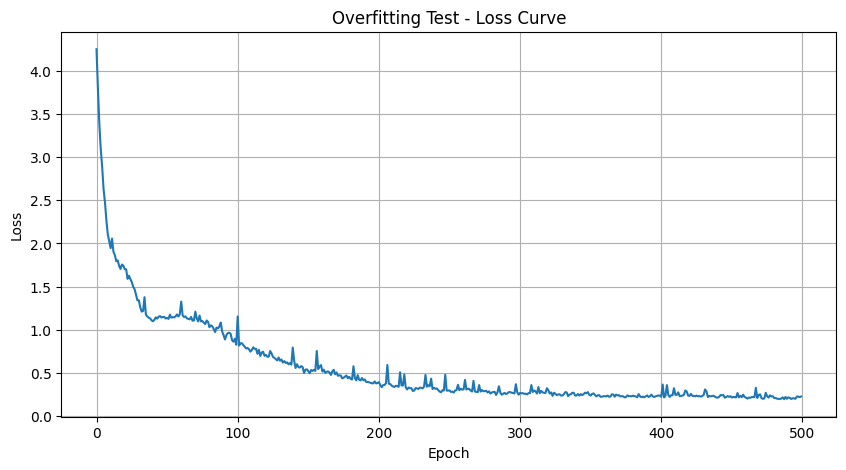

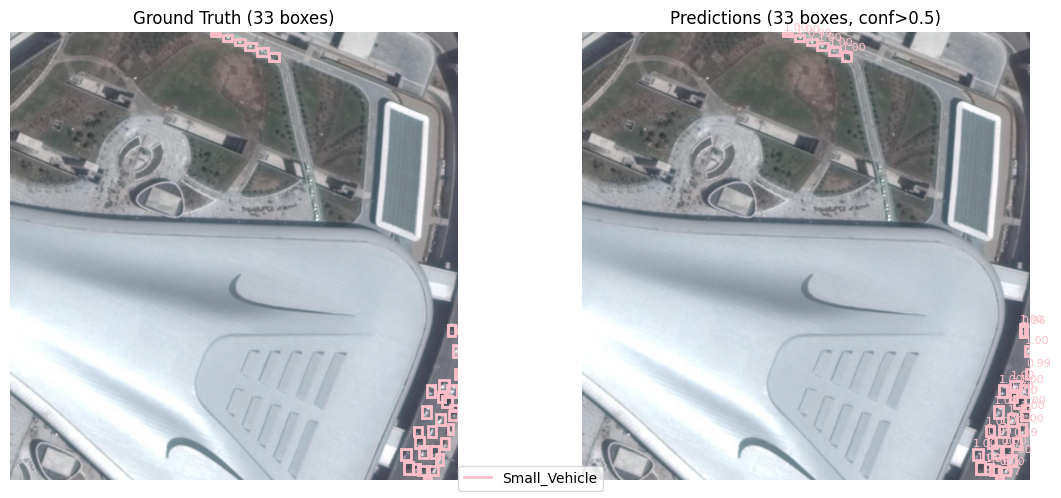


Found 33 boxes (should be 33)

RESULTS:
Initial Loss: 4.2521
Final Loss: 0.2242
Improvement: 94.7%


In [9]:
losses, preds = overfit_single_image_test(
    model, train_dataset, idx=19, num_epochs=500, device=device
)

## Training

Full training with the Trainer class.


In [10]:
# Re-create model (fresh weights)
model = get_custom_maskrcnn(num_classes=num_classes, pretrained_backbone=True)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 197MB/s]


In [ ]:
trainer = Trainer(
    data_root=root_dir,
    num_classes=num_classes,
    batch_size=2,
    lr=0.0001,
    device=device,
    use_amp=True,
    subset_fraction=0.2,
)

Loading datasets...
Filtered dataset: 18732 images with annotations
Filtered dataset: 6048 images with annotations
Using 20.0% of data: 3746 train, 1209 val samples
Creating model...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 172MB/s]


Device: cuda
AMP enabled: True
Train samples: 3746
Val samples: 1209


In [ ]:
trainer.fit(epochs=20, save_dir="checkpoints")


Epoch 1/20


Train Epoch 1:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.5571 | Val Loss: 1.6253 | Time: 705.5s
-> New best model saved

Epoch 2/20


Train Epoch 2:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3980 | Val Loss: 1.6356 | Time: 697.4s

Epoch 3/20


Train Epoch 3:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3621 | Val Loss: 1.5990 | Time: 694.3s
-> New best model saved

Epoch 4/20


Train Epoch 4:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3454 | Val Loss: 1.5557 | Time: 697.7s
-> New best model saved

Epoch 5/20


Train Epoch 5:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3260 | Val Loss: 1.5721 | Time: 698.5s

Epoch 6/20


Train Epoch 6:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3159 | Val Loss: 1.5236 | Time: 698.5s
-> New best model saved

Epoch 7/20


Train Epoch 7:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.3012 | Val Loss: 1.5176 | Time: 699.6s
-> New best model saved

Epoch 8/20


Train Epoch 8:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.2893 | Val Loss: 1.5131 | Time: 691.0s
-> New best model saved

Epoch 9/20


Train Epoch 9:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.2882 | Val Loss: 1.4938 | Time: 690.6s
-> New best model saved

Epoch 10/20


Train Epoch 10:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.2809 | Val Loss: 1.4524 | Time: 691.1s
-> New best model saved

Epoch 11/20


Train Epoch 11:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.2454 | Val Loss: 1.4246 | Time: 695.1s
-> New best model saved

Epoch 12/20


Train Epoch 12:   0%|          | 0/1873 [00:00<?, ?it/s]

Validation:   0%|          | 0/1209 [00:00<?, ?it/s]

Train Loss: 1.2365 | Val Loss: 1.4263 | Time: 695.8s

Epoch 13/20


Train Epoch 13:   0%|          | 0/1873 [00:00<?, ?it/s]

## Load Best Model and Evaluate

Load the best checkpoint and evaluate on validation set.


In [ ]:
# Load best checkpoint
checkpoint = trainer.load_checkpoint("checkpoints/best.pth")
trainer.model.eval()
print("Loaded best model")

In [ ]:
# Evaluate on validation set
val_losses = trainer.validate()
print("\nValidation Results:")
for k, v in val_losses.items():
    print(f"  {k}: {v:.4f}")

## Visualize


In [ ]:
# Visualize predictions on validation set
trainer.visualize_predictions(num_samples=5, score_threshold=0.5)

In [ ]:
# Quick inference on a single sample
from training.transforms import get_transforms

idx = 50
image, target = val_dataset[idx]
image_tensor = (
    get_transforms(train=False)(image) if not isinstance(image, torch.Tensor) else image
)

with torch.no_grad():
    pred = trainer.model([image_tensor.to(device)])[0]

print(f"Found {len(pred['boxes'])} detections")
print(f"Ground truth has {len(target['boxes'])} objects")